# Notebook to look at COVID-19 impacts on traffic congestion

In [29]:
# load dependencies
import pandas as pd
import boto3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import matplotlib.gridspec as gridspec
import datetime as dt

# Clean Dataset

#### Function to clean dataset

In [30]:
 def df_process(df, col_name):
    
    # convert UTC to local time
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['datetime'] = df['datetime'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
    
    # set datetime as index
    df.set_index('datetime',inplace=True)
    df.sort_index(inplace=True)
    
    # give common column names
    df.columns = col_name
    
    # change data type to integer
    df = df.astype('int64')

    # convert seconds to minutes and roundoff
    df = round(df/60,1)

    return df

#### Create dataframe and clean dataset

In [40]:
# create dataframe
df = pd.read_csv('GoogleMaps_Drive_Times_UNCLEANED.csv')

# cleanup dataset
new_col_names = ['Vancouver_to_Squamish','Squamish_to_East-Vancouver','East-Vancouver_to_Squamish','Squamish_to_Vancouver']
df = df_process(df, new_col_names)

# save cleaned dataset
df.to_csv('GoogleMaps_Drive_Times_CLEANED.csv')

# Dataset filters

#### Transform drive time data to traffic congestion

In [11]:
# data presently represents drive times based on Google Maps API. Instead, convert data to traffic congestion
# as compared to baseline drive time.

# define baseline drive time as average drive time at 2am Monday through Friday
baseline_drive_times = (df[(df.index.weekday<5) & (df.index.hour==2)]).mean()

# convert drive times to congestion relative to baseline drive times
df_congestion = df.copy()
df_congestion = (1 - baseline_drive_times / df_congestion) * 100

#### Define pre and post covid date

In [12]:
# split dataset "pre" and "post" COVID-19, defined as the day PM Trudeau announced nationwide restrictions
covid_start = 'March 16 2020'

df_congestion_pre = df_congestion[df_congestion.index<covid_start]
df_congestion_post = df_congestion[df_congestion.index>=covid_start]

# Plot dataset

#### Plot settings

In [13]:
# fontsize
tick_fontsize = '14'
label_fontsize = '16'
title_fontsize = '18'
legend_fontsize = '12'

# bar plot widths
day_of_week_width = 0.40
hour_of_day_width = 0.15

# day of week labels
labels_dow = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

#### Plotting functions

In [14]:
# function to put labels over bar plots
def autolabel(rects, label):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if height<0:
            voffset = -15
        else:
            voffset = 3
        
        ax.annotate('{}%'.format(int(label[i])),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, voffset),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize='12',color='red')

#### Time series drive time pre and post covid

/home/dlhurley/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


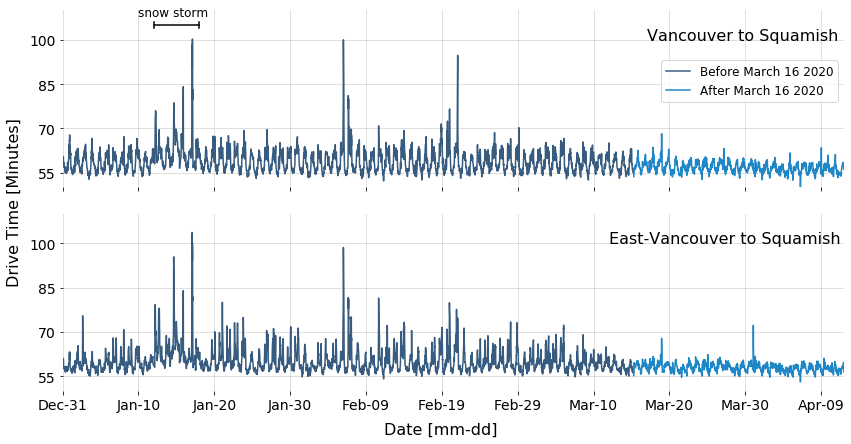

In [15]:
# force matplotlib to plot in correct timezone
matplotlib.rcParams['timezone'] = 'US/Pacific'
formatter = mdates.DateFormatter('%b-%d',tz=df_congestion_pre.index.tz)

# define figure
fig = plt.figure(figsize=(14,7))

# define grid spacing and axis labels
gs1 = gridspec.GridSpec(2, 1,hspace=0.15)
fig.text(0.07, 0.5, 'Drive Time [Minutes]', va='center', rotation='vertical',fontsize=label_fontsize)
fig.text(0.5, 0.04, 'Date [mm-dd]', ha='center',fontsize=label_fontsize)

# time series vancouver to squamish
ax = fig.add_subplot(gs1[0])
ax.plot(df['Vancouver_to_Squamish'][df.index<covid_start],color='#375c80',label='Before ' + covid_start)
ax.plot(df['Vancouver_to_Squamish'][df.index>=covid_start],color='#2087c7',label='After ' + covid_start)

# plot snow storm
ax.plot([pd.Timestamp(2020,1,13),pd.Timestamp(2020,1,19)],[105,105],'k')
ax.plot([pd.Timestamp(2020,1,13),pd.Timestamp(2020,1,13)],[104,106],'k')
ax.plot([pd.Timestamp(2020,1,19),pd.Timestamp(2020,1,19)],[104,106],'k')
ax.text(pd.Timestamp(2020,1,11),108,'snow storm',fontsize=legend_fontsize)

# add labels,legends, and properties
ax.legend(fontsize=legend_fontsize,loc='right',bbox_to_anchor=(1,0.6))
ax.text(pd.Timestamp(2020,3,18),100,'Vancouver to Squamish',fontsize=label_fontsize)
ax.grid()
ax.set_xlim(['2020-01-01', '2020-04-13'])
ax.set_ylim([50,110])
ax.set_yticks(range(55,110,15))
ax.set_xticks(pd.date_range('2020-01-01','2020-04-10',freq='10d'))
ax.set_xticklabels([])
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# timeseries plot East Vancouver to Squamish
ax = fig.add_subplot(gs1[1])
ax.plot(df['East-Vancouver_to_Squamish'][df.index<covid_start],color='#375c80',label='Before ' + covid_start)
ax.plot(df['East-Vancouver_to_Squamish'][df.index>=covid_start],color='#2087c7',label='After ' + covid_start)

# add labels,legends, and properties
ax.text(pd.Timestamp(2020,3,13),100,'East-Vancouver to Squamish',fontsize=label_fontsize)
ax.grid()
ax.set_xlim(['2020-01-01', '2020-04-13'])
ax.set_ylim([50,110])
ax.set_yticks(range(55,110,15))
ax.set_xticks(pd.date_range('2020-01-01','2020-04-10',freq='10d'))
ax.xaxis.set_major_formatter(formatter)
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# save figure
fig.savefig('Drive Time: Sea to Sky.png', dpi=900)

#### Time series congestion pre and post covid

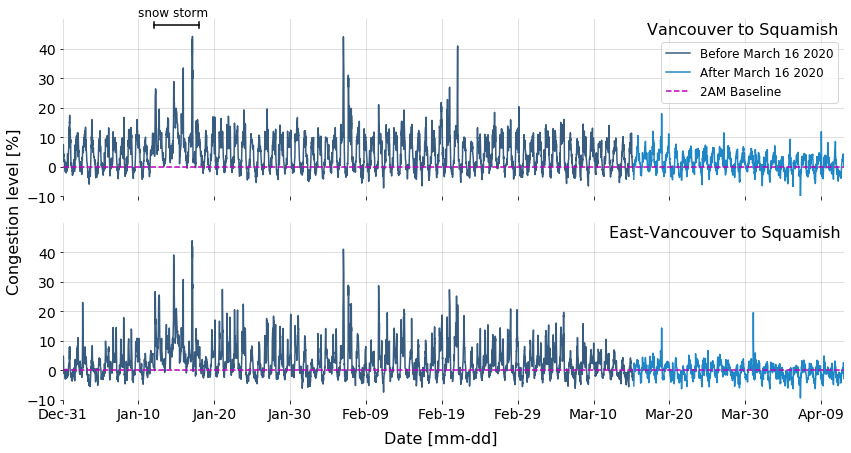

In [16]:
# force matplotlib to plot in correct timezone
matplotlib.rcParams['timezone'] = 'US/Pacific'
formatter = mdates.DateFormatter('%b-%d',tz=df_congestion_pre.index.tz)

# define figure
fig = plt.figure(figsize=(14,7))

# define grid spacing and axis labels
gs1 = gridspec.GridSpec(2, 1,hspace=0.15)
fig.text(0.07, 0.5, 'Congestion level [%]', va='center', rotation='vertical',fontsize=label_fontsize)
fig.text(0.5, 0.04, 'Date [mm-dd]', ha='center',fontsize=label_fontsize)

# time series vancouver to squamish
ax = fig.add_subplot(gs1[0])
ax.plot(df_congestion_pre['Vancouver_to_Squamish'],color='#375c80',label='Before ' + covid_start)
ax.plot(df_congestion_post['Vancouver_to_Squamish'],color='#2087c7',label='After ' + covid_start)
ax.axhline(0,color='m',linestyle='--',label='2AM Baseline')

# plot snow storm
ax.plot([pd.Timestamp(2020,1,13),pd.Timestamp(2020,1,19)],[48,48],'k')
ax.plot([pd.Timestamp(2020,1,13),pd.Timestamp(2020,1,13)],[47,49],'k')
ax.plot([pd.Timestamp(2020,1,19),pd.Timestamp(2020,1,19)],[47,49],'k')
ax.text(pd.Timestamp(2020,1,11),51,'snow storm',fontsize=legend_fontsize)

# add labels,legends, and properties
ax.legend(fontsize=legend_fontsize,loc='right',bbox_to_anchor=(1,0.7))
ax.text(pd.Timestamp(2020,3,18),45,'Vancouver to Squamish',fontsize=label_fontsize)
ax.grid()
ax.set_xlim(['2020-01-01', '2020-04-13'])
ax.set_ylim([-10,50])
ax.set_yticks(range(-10,50,10))
ax.set_xticks(pd.date_range('2020-01-01','2020-04-10',freq='10d'))
ax.set_xticklabels([])
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# timeseries plot East Vancouver to Squamish
ax = fig.add_subplot(gs1[1])
ax.plot(df_congestion_pre['East-Vancouver_to_Squamish'],color='#375c80',label='Before ' + covid_start)
ax.plot(df_congestion_post['East-Vancouver_to_Squamish'],color='#2087c7',label='After ' + covid_start)
ax.axhline(0,color='m',linestyle='--',label='2AM Baseline')

# add labels,legends, and properties
ax.text(pd.Timestamp(2020,3,13),45,'East-Vancouver to Squamish',fontsize=label_fontsize)
ax.grid()
ax.set_xlim(['2020-01-01', '2020-04-13'])
ax.set_ylim([-10,50])
ax.set_yticks(range(-10,50,10))
ax.set_xticks(pd.date_range('2020-01-01','2020-04-10',freq='10d'))
ax.xaxis.set_major_formatter(formatter)
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# save figure
fig.savefig('Congestion: Sea to Sky.png', dpi=900)

#### Bar plot of traffic congestion Monday through Friday between 7am and 7pm

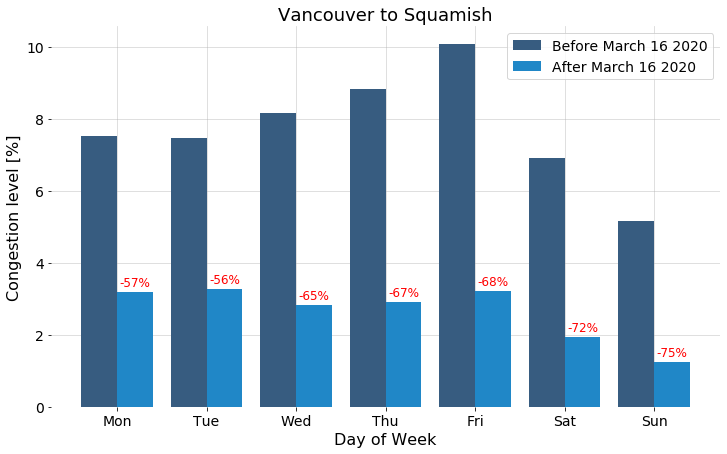

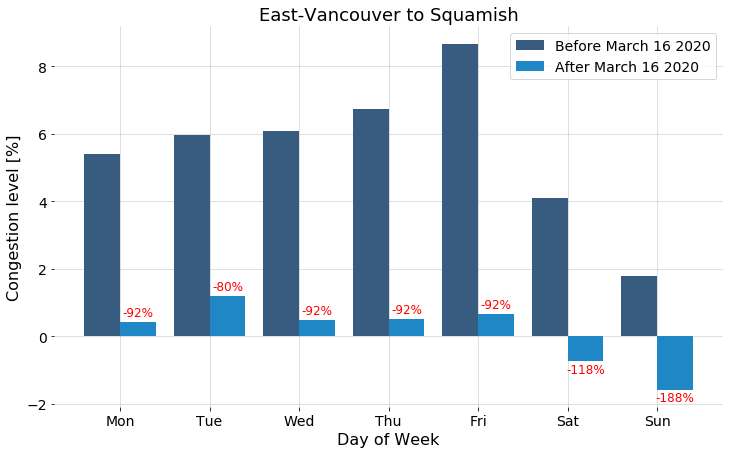

In [17]:
# define hours to filter on
start_hour = 7
end_hour = 19

# define filter function
def dow_filter(df,start_hour,end_hour):
    df = df[(df.index.hour >= start_hour) & (df.index.hour <= end_hour)]
    df = df.groupby(df.index.weekday).mean()
    return df

# filter dataset between 7am and 7pm and calculate average by day of week
df_congestion_pre_mean = dow_filter(df_congestion_pre,start_hour,end_hour)
df_congestion_post_mean = dow_filter(df_congestion_post,start_hour,end_hour)

# make bar plot Vancouver to Squamish 
fig,ax = plt.subplots(1,1,figsize=(12,7))

rect1 = ax.bar(df_congestion_pre_mean.index-day_of_week_width/2, \
               df_congestion_pre_mean['Vancouver_to_Squamish'],day_of_week_width, \
               label='Before ' + covid_start, color='#375c80')

rect2 = ax.bar(df_congestion_post_mean.index+day_of_week_width/2, \
               df_congestion_post_mean['Vancouver_to_Squamish'],day_of_week_width, \
               label='After ' + covid_start, color='#2087c7')

# add labels,legends, and properties
ax.set_xticks(df_congestion_post_mean.index)
ax.set_xticklabels(labels_dow)
ax.legend(fontsize=tick_fontsize)
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.set_xlabel('Day of Week', fontsize=label_fontsize)
ax.set_ylabel('Congestion level [%]', fontsize=label_fontsize)
ax.set_title('Vancouver to Squamish', fontsize=title_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# add labels for percent change pre and post covid
percent_change = -1 * (1 - df_congestion_post_mean/df_congestion_pre_mean) * 100
autolabel(rect2, percent_change['Vancouver_to_Squamish'])

# save figure
fig.savefig('Congestion: Vacouver to Squamish.png', dpi=1200)

# make bar plot East Vancouver to Squamish 
fig,ax = plt.subplots(1,1,figsize=(12,7))

rect1 = ax.bar(df_congestion_pre_mean.index-day_of_week_width/2, \
               df_congestion_pre_mean['East-Vancouver_to_Squamish'],day_of_week_width, \
               label='Before ' + covid_start, color='#375c80')

rect2 = ax.bar(df_congestion_post_mean.index+day_of_week_width/2, \
               df_congestion_post_mean['East-Vancouver_to_Squamish'],day_of_week_width, \
               label='After ' + covid_start, color='#2087c7')

# add labels,legends, and properties
ax.set_xticks(df_congestion_post_mean.index)
ax.set_xticklabels(labels_dow)
ax.legend(fontsize=tick_fontsize)
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.set_xlabel('Day of Week', fontsize=label_fontsize)
ax.set_ylabel('Congestion level [%]', fontsize=label_fontsize)
ax.set_title('East-Vancouver to Squamish', fontsize=title_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# add labels for percent change pre and post covid
percent_change = -1 * (1 - df_congestion_post_mean/df_congestion_pre_mean) * 100
autolabel(rect2, percent_change['East-Vancouver_to_Squamish'])

# save figure
fig.savefig('Congestion: East-Vacouver to Squamish.png', dpi=1200)

#### Bar plot of traffic congestion Monday through Friday by hour between 7am and 7pm

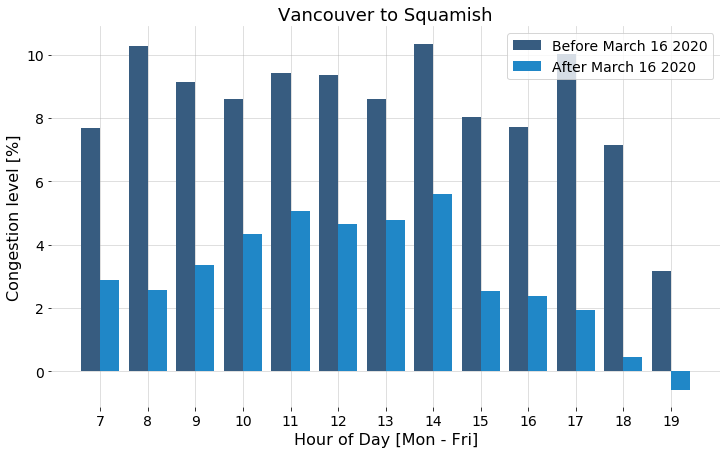

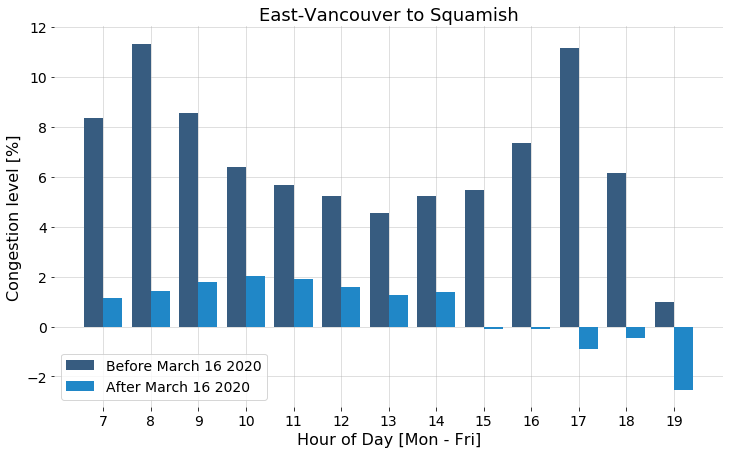

In [18]:
# define hours to filter on
start_hour = 7
end_hour = 19

# define filter function
def hod_weekday_filter(df,start_hour,end_hour):
    df = df[(df.index.weekday < 5) & (df.index.hour >= start_hour) & (df.index.hour <= end_hour)]
    df = df.groupby(df.index.hour).mean()
    return df

# filter dataset to average congestion saturday and sunday
df_congestion_pre_mean = hod_weekday_filter(df_congestion_pre,start_hour,end_hour)
df_congestion_post_mean = hod_weekday_filter(df_congestion_post,start_hour,end_hour)

# make bar plot Vancouver to Squamish 
fig,ax = plt.subplots(1,1,figsize=(12,7))

rect1 = ax.bar(df_congestion_pre_mean.index-day_of_week_width/2, \
               df_congestion_pre_mean['Vancouver_to_Squamish'],day_of_week_width, \
               label='Before ' + covid_start, color='#375c80')

rect2 = ax.bar(df_congestion_post_mean.index+day_of_week_width/2, \
               df_congestion_post_mean['Vancouver_to_Squamish'],day_of_week_width, \
               label='After ' + covid_start, color='#2087c7')

# add labels,legends, and properties
ax.set_xticks(df_congestion_post_mean.index)
ax.legend(fontsize=tick_fontsize)
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.set_xlabel('Hour of Day [Mon - Fri]', fontsize=label_fontsize)
ax.set_ylabel('Congestion level [%]', fontsize=label_fontsize)
ax.set_title('Vancouver to Squamish', fontsize=title_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# save figure
fig.savefig('Congestion: Vancouver to Squamish M-F Hour of Day.png', dpi=1200)

# make bar plot East Vancouver to Squamish 
fig,ax = plt.subplots(1,1,figsize=(12,7))

rect1 = ax.bar(df_congestion_pre_mean.index-day_of_week_width/2, \
               df_congestion_pre_mean['East-Vancouver_to_Squamish'],day_of_week_width, \
               label='Before ' + covid_start, color='#375c80')

rect2 = ax.bar(df_congestion_post_mean.index+day_of_week_width/2, \
               df_congestion_post_mean['East-Vancouver_to_Squamish'],day_of_week_width, \
               label='After ' + covid_start, color='#2087c7')

# add labels,legends, and properties
ax.set_xticks(df_congestion_post_mean.index)
ax.legend(fontsize=tick_fontsize)
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.set_xlabel('Hour of Day [Mon - Fri]', fontsize=label_fontsize)
ax.set_ylabel('Congestion level [%]', fontsize=label_fontsize)
ax.set_title('East-Vancouver to Squamish', fontsize=title_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# save figure
fig.savefig('Congestion: East-Vancouver to Squamish M-F Hour of Day.png', dpi=1200)

#### Bar plot of traffic congestion Saturday and Sunday by hour between 7am and 7pm

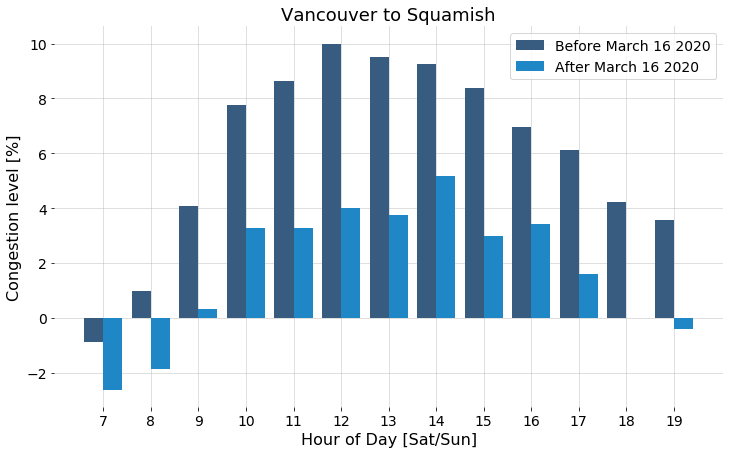

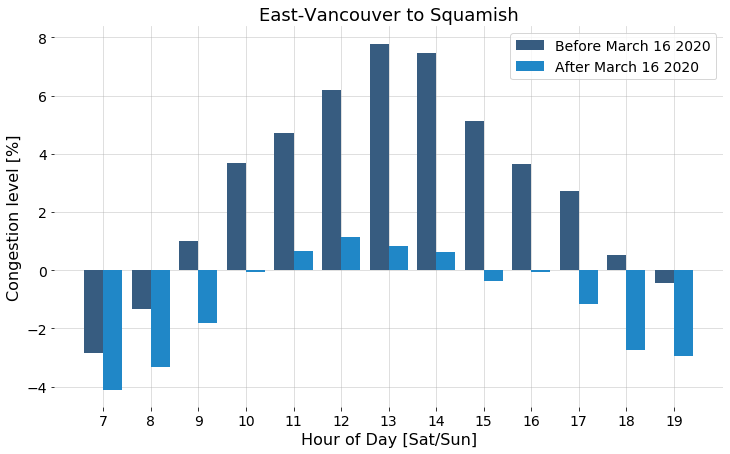

In [19]:
# define filter function
def hod_weekend_filter(df,start_hour,end_hour):
    df = df[(df.index.weekday > 4) & (df.index.hour >= start_hour) & (df.index.hour <= end_hour)]
    df = df.groupby(df.index.hour).mean()
    return df

# filter dataset to average congestion saturday and sunday
df_congestion_pre_mean = hod_weekend_filter(df_congestion_pre,start_hour,end_hour)
df_congestion_post_mean = hod_weekend_filter(df_congestion_post,start_hour,end_hour)

# make bar plot Vancouver to Squamish 
fig,ax = plt.subplots(1,1,figsize=(12,7))

rect1 = ax.bar(df_congestion_pre_mean.index-day_of_week_width/2, \
               df_congestion_pre_mean['Vancouver_to_Squamish'],day_of_week_width, \
               label='Before ' + covid_start, color='#375c80')

rect2 = ax.bar(df_congestion_post_mean.index+day_of_week_width/2, \
               df_congestion_post_mean['Vancouver_to_Squamish'],day_of_week_width, \
               label='After ' + covid_start, color='#2087c7')

# add labels,legends, and properties
ax.set_xticks(df_congestion_post_mean.index)
ax.legend(fontsize=tick_fontsize)
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.set_xlabel('Hour of Day [Sat/Sun]', fontsize=label_fontsize)
ax.set_ylabel('Congestion level [%]', fontsize=label_fontsize)
ax.set_title('Vancouver to Squamish', fontsize=title_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# save figure
fig.savefig('Congestion: Vancouver to Squamish Weekend Hour of Day.png', dpi=1200)

# make bar plot East Vancouver to Squamish 
fig,ax = plt.subplots(1,1,figsize=(12,7))

rect1 = ax.bar(df_congestion_pre_mean.index-day_of_week_width/2, \
               df_congestion_pre_mean['East-Vancouver_to_Squamish'],day_of_week_width, \
               label='Before ' + covid_start, color='#375c80')

rect2 = ax.bar(df_congestion_post_mean.index+day_of_week_width/2, \
               df_congestion_post_mean['East-Vancouver_to_Squamish'],day_of_week_width, \
               label='After ' + covid_start, color='#2087c7')

# add labels,legends, and properties
ax.set_xticks(df_congestion_post_mean.index)
ax.legend(fontsize=tick_fontsize)
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.set_xlabel('Hour of Day [Sat/Sun]', fontsize=label_fontsize)
ax.set_ylabel('Congestion level [%]', fontsize=label_fontsize)
ax.set_title('East-Vancouver to Squamish', fontsize=title_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# save figure
fig.savefig('Congestion: East-Vancouver to Squamish Weekend Hour of Day.png', dpi=1200)

#### Bar plot of average weekend pre covid and select weekends by hour between 9am to 2pm

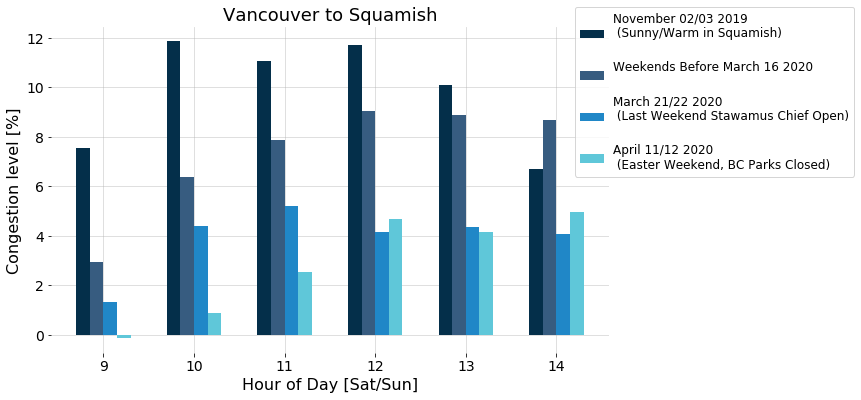

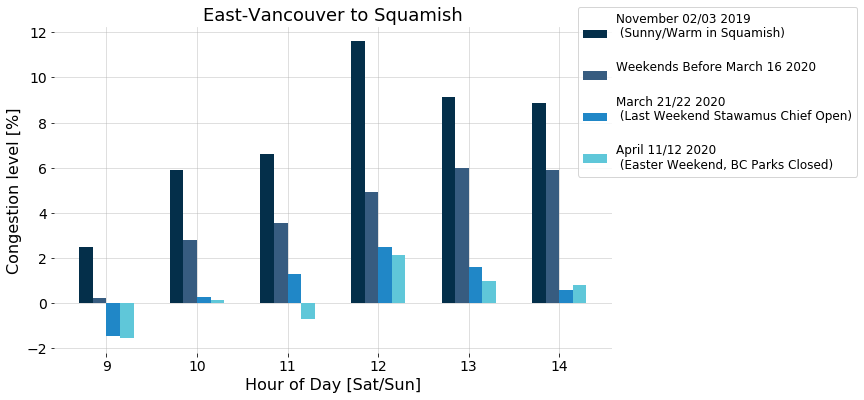

In [20]:
# filter hours
start_hour = 9
end_hour = 14

# March 21
start_march_21 = '2020-03-21'
end_march_21 = '2020-03-23'

# April 11
start_april_11 = '2020-04-11'
end_april_11 = '2020-04-13'

# November 02
start_november_02 = '2019-11-02'
end_november_02 = '2019-11-04'

# define filter functions
def saturday_filter(df,start_hour,end_hour):
    df = df[(df.index.weekday > 5) & (df.index.hour >= start_hour) & (df.index.hour <= end_hour)]
    df = df.groupby(df.index.hour).mean()
    return df

def select_day_filter(df,start_hour,end_hour,start_date,end_date):
    df = df[(df.index > start_date) & (df.index < end_date) & \
            (df.index.hour >= start_hour) & (df.index.hour <= end_hour)]
    df = df.groupby(df.index.hour).mean()
    return df

# filter dataset to average congestion saturday pre and post
df_congestion_pre_mean = saturday_filter(df_congestion_pre,start_hour,end_hour)
df_congestion_post_mean = saturday_filter(df_congestion_post,start_hour,end_hour)
df_congestion_march21_mean = select_day_filter(df_congestion_post,start_hour,end_hour, \
                                               start_march_21,end_march_21)
df_congestion_april11_mean = select_day_filter(df_congestion_post,start_hour,end_hour, \
                                               start_april_11,end_april_11)
df_congestion_november02_mean = select_day_filter(df_congestion_pre,start_hour,end_hour, \
                                                  start_november_02,end_november_02)


# make bar plot Vancouver to Squamish 
fig,ax = plt.subplots(1,1,figsize=(10,6))

rect5 = ax.bar(df_congestion_november02_mean.index-0.225, \
              df_congestion_november02_mean['Vancouver_to_Squamish'],width=0.15, \
              label='November 02/03 2019\n (Sunny/Warm in Squamish)\n', color='#042f4a')

rect1 = ax.bar(df_congestion_pre_mean.index-0.075, \
               df_congestion_pre_mean['Vancouver_to_Squamish'],width=0.15, \
               label='Weekends Before ' + covid_start+'\n', color='#375c80')

rect3 = ax.bar(df_congestion_march21_mean.index+0.075,\
               df_congestion_march21_mean['Vancouver_to_Squamish'],width=0.15,\
               label='March 21/22 2020\n (Last Weekend Stawamus Chief Open)\n', color='#2087c7')

rect4 = ax.bar(df_congestion_april11_mean.index+0.225, \
               df_congestion_april11_mean['Vancouver_to_Squamish'],width=0.15, \
               label='April 11/12 2020\n (Easter Weekend, BC Parks Closed)', color='#5fc7d9')

# add labels,legends, and properties
ax.set_xticks(df_congestion_post_mean.index)
ax.legend(loc='right',bbox_to_anchor=(1.45,0.8),fontsize=legend_fontsize)
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.set_xlabel('Hour of Day [Sat/Sun]', fontsize=label_fontsize)
ax.set_ylabel('Congestion level [%]', fontsize=label_fontsize)
ax.set_title('Vancouver to Squamish', fontsize=title_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# save figure
fig.savefig('Congestion: Vancouver to Squamish Select Weekends.png',bbox_inches='tight',dpi=900)

# make bar plot Vancouver to Squamish 
fig,ax = plt.subplots(1,1,figsize=(10,6))

rect5 = ax.bar(df_congestion_november02_mean.index-0.225, \
              df_congestion_november02_mean['East-Vancouver_to_Squamish'],width=0.15, \
              label='November 02/03 2019\n (Sunny/Warm in Squamish)\n', color='#042f4a')

rect1 = ax.bar(df_congestion_pre_mean.index-0.075, \
               df_congestion_pre_mean['East-Vancouver_to_Squamish'],width=0.15, \
               label='Weekends Before ' + covid_start+'\n', color='#375c80')

rect3 = ax.bar(df_congestion_march21_mean.index+0.075,\
               df_congestion_march21_mean['East-Vancouver_to_Squamish'],width=0.15,\
               label='March 21/22 2020\n (Last Weekend Stawamus Chief Open)\n', color='#2087c7')

rect4 = ax.bar(df_congestion_april11_mean.index+0.225, \
               df_congestion_april11_mean['East-Vancouver_to_Squamish'],width=0.15, \
               label='April 11/12 2020\n (Easter Weekend, BC Parks Closed)', color='#5fc7d9')

# add labels,legends, and properties
ax.set_xticks(df_congestion_post_mean.index)
lgd = ax.legend(loc='right',bbox_to_anchor=(1.45,0.8),fontsize=legend_fontsize)
ax.tick_params(axis='both',labelsize=tick_fontsize)
ax.set_xlabel('Hour of Day [Sat/Sun]', fontsize=label_fontsize)
ax.set_ylabel('Congestion level [%]', fontsize=label_fontsize)
ax.set_title('East-Vancouver to Squamish', fontsize=title_fontsize)
ax.grid(zorder=1,alpha=0.5)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# save figure
fig.savefig('Congestion: East-Vancouver to Squamish Select Weekends.png',bbox_inches='tight',dpi=900)